In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
import math
import gc
import ipaddress
from urllib.parse import urlparse
from tldextract import extract
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
from collections import Counter

import sys
from pathlib import Path
d = Path().resolve().parent.parent
sys.path.insert(0, str(d))
import util.utils as utils
import util.plot_utils as plot_utils

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

np.set_printoptions(threshold=np.nan)

from sklearn.linear_model import LinearRegression



plt.rcParams["figure.figsize"] = (12,4)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from datetime import datetime


InteractiveShell.ast_node_interactivity = "all"

### Features
- dates
    - dayofyear
    - weekofyear
    - dayofweek
    - dayofmonth (salary credit effect)
    - Holidays from date_info.csv
- Visitors and reserve visitors
- Take all hotels for model, even ones not in submmission file
- Area by lat long
- reserve visitors can be used by per restaurant per day to gain some kind of intuition
- LabelEncode Store info

In [2]:

def label_encode_field(df,field):
    df[field] = df[field].fillna('-1')
    encoded_df = df[field]
    label_encoder = LabelEncoder()
    encoder = label_encoder.fit(encoded_df.values)
    
    encoded_df=encoder.transform(df[field].fillna("-1").values)
    df[field+"_encoded"] = encoded_df
    return encoder

df_air_store_info = pd.read_csv("data/air_store_info.csv")
label_encode_field(df_air_store_info,"air_genre_name")
label_encode_field(df_air_store_info,"air_store_id")
label_encode_field(df_air_store_info,"air_area_name")
df_air_store_info["air_lat_long"]=df_air_store_info["latitude"].astype(str)+"_"+df_air_store_info["longitude"].astype(str)
label_encode_field(df_air_store_info,"air_lat_long")

df_hpg_store_info = pd.read_csv("data/hpg_store_info.csv")
df_store_id_relation = pd.read_csv("data/store_id_relation.csv")
df_air_visit_data = pd.read_csv("data/air_visit_data.csv")

df_date_info = pd.read_csv("data/date_info.csv")
df_date_info.drop(['day_of_week'], axis = 1, inplace = True)
df_date_info["visit_date"]=df_date_info["calendar_date"]
df_date_info.drop(['calendar_date'], axis = 1, inplace = True)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [3]:
def add_dates(df,date_col,date_format=None):
    timeseries = None
    if(date_format is None):
        timeseries = pd.to_datetime(df[date_col])
    else:
        timeseries = pd.to_datetime(df[date_col],format=date_format)
    df["dayofyear"] = timeseries.map(lambda x:x.dayofyear)
    df["dayofweek"] = timeseries.map(lambda x:x.dayofweek)
    df["weekofyear"] = timeseries.map(lambda x:x.weekofyear)
    df.loc[df["weekofyear"]==53,"weekofyear"] = 1
    df["dayofmonth"] = timeseries.map(lambda x:x.date().day)
    df["visit_date"] = timeseries.map(lambda x:str(x.date()))
    df = pd.merge(df,df_date_info,on="visit_date", how='left')
    #df.join(df_date_info,on='visit_date',how='left')
    return df
    
    

df_hpg_reserve = pd.read_csv("data/hpg_reserve.csv")

df_air_reserve = pd.read_csv("data/air_reserve.csv")

df_air_reserve = pd.merge(df_air_reserve,df_air_store_info,on='air_store_id', how='left')
df_air_reserve.drop(['reserve_datetime'], axis = 1, inplace = True)
df_hpg_reserve = pd.merge(df_hpg_reserve,df_hpg_store_info,on='hpg_store_id', how='left')
df_hpg_reserve.drop(['reserve_datetime'], axis = 1, inplace = True)

df_air_reserve=add_dates(df_air_reserve,"visit_datetime")
df_hpg_reserve=add_dates(df_hpg_reserve,"visit_datetime")



In [4]:
df_air_visit_data = pd.merge(df_air_visit_data,df_air_store_info,on='air_store_id', how='left')
df_air_visit_data = add_dates(df_air_visit_data,"visit_date")

In [5]:
sample_sub = pd.read_csv("data/sample_submission.csv")
len(sample_sub)

pred_ids = sample_sub.id.map(lambda x:x[:-11])
sample_sub["air_store_id"] = pred_ids
pred_dates = sample_sub.id.map(lambda x:x[-10:])
sample_sub["visit_date"] = pred_dates
sample_sub = add_dates(sample_sub,"visit_date")
sample_sub = pd.merge(sample_sub,df_air_store_info,on='air_store_id', how='left')



32019

In [6]:
# df_hpg_reserve.to_csv("data/stage-2/hpg_reserve.csv")

# df_air_reserve.to_csv("data/stage-2/air_reserve.csv")

# df_air_store_info.to_csv("data/stage-2/air_store_info.csv")

# df_date_info.to_csv("data/stage-2/date_info.csv")

# df_air_visit_data.to_csv("data/stage-2/air_visit_data.csv")
# sample_sub.to_csv("data/stage-2/sample_submission.csv")

In [7]:
df_air_visit_data.columns
output_column=["visitors"]
features = ["air_genre_name_encoded","air_store_id_encoded", 'air_area_name_encoded','air_lat_long_encoded', 'dayofyear', 'dayofweek', 'weekofyear',
       'dayofmonth', 'holiday_flg']
df_air_visit_data[features].dtypes

Index(['air_store_id', 'visit_date', 'visitors', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'air_genre_name_encoded',
       'air_store_id_encoded', 'air_area_name_encoded', 'air_lat_long',
       'air_lat_long_encoded', 'dayofyear', 'dayofweek', 'weekofyear',
       'dayofmonth', 'holiday_flg'],
      dtype='object')

air_genre_name_encoded    int64
air_store_id_encoded      int64
air_area_name_encoded     int64
air_lat_long_encoded      int64
dayofyear                 int64
dayofweek                 int64
weekofyear                int64
dayofmonth                int64
holiday_flg               int64
dtype: object

In [8]:
X = df_air_visit_data[features].values
y = df_air_visit_data[output_column]
X_pred = sample_sub[features].values

gc.collect()
xgr=xgb.XGBRegressor(n_estimators=250, learning_rate=0.7, gamma=0,max_depth=8,n_jobs=4)
xgr.fit(X,y)

def xgr_predict(X):
    pred=xgr.predict(X)
    pred[pred<=0]=1
    return pred

82

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [9]:
df_air_mean_visits = df_air_visit_data.groupby(["air_store_id"],as_index=False).mean()

y_preds = xgr_predict(X_pred)
def loss(Y,A):
    length = len(Y)
    return np.sqrt(np.sum(np.square(np.log(Y) - np.log(A)))/length)
loss(df_air_visit_data["visitors"],df_air_mean_visits["visitors"])
loss(y["visitors"],xgr_predict(X))


0.07802537852290678

0.54611513019122737

### Plots
#### Links
- [Matplotlib line graph](https://matplotlib.org/2.0.2/users/pyplot_tutorial.html)

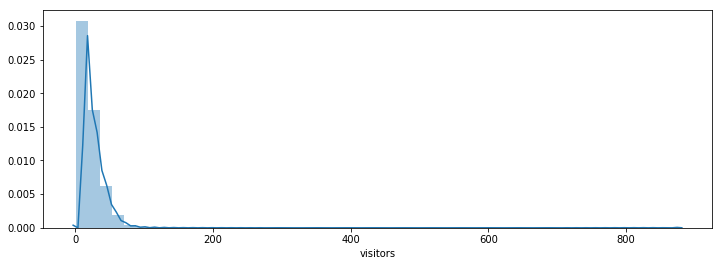

In [10]:
sns.distplot(df_air_visit_data["visitors"])


=========== Total visitors by dayofweek==========


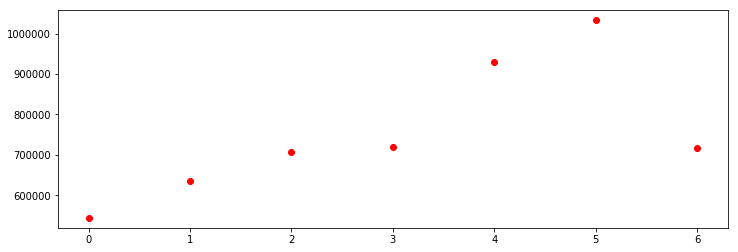

=========== Total visitors by dayofmonth==========


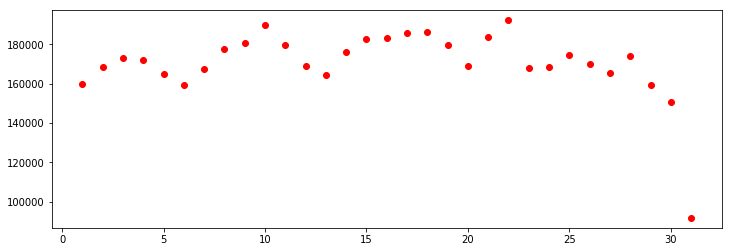

=========== Total visitors by holiday_flg==========


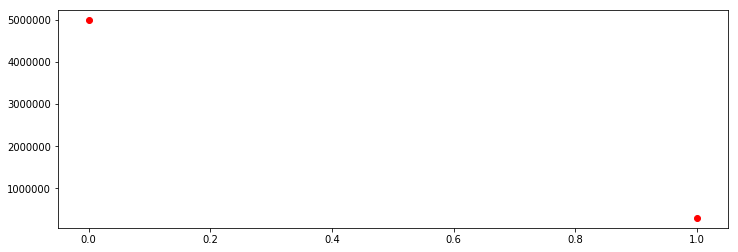

=========== Mean visitors by dayofweek==========


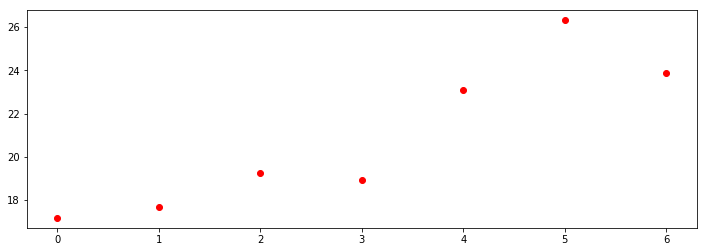

=========== Mean visitors by dayofmonth==========


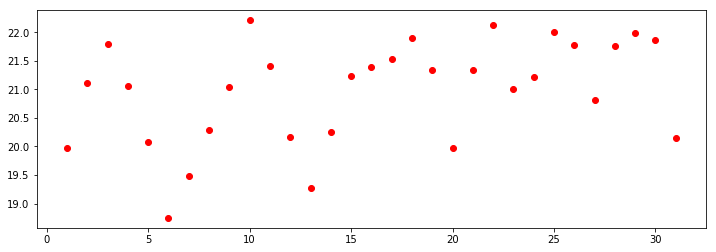

=========== Mean visitors by holiday_flg==========


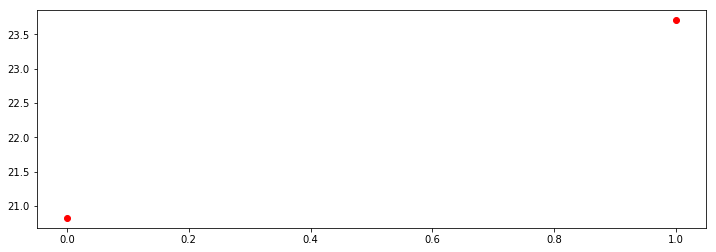

=========== visitors by air_genre_name==========


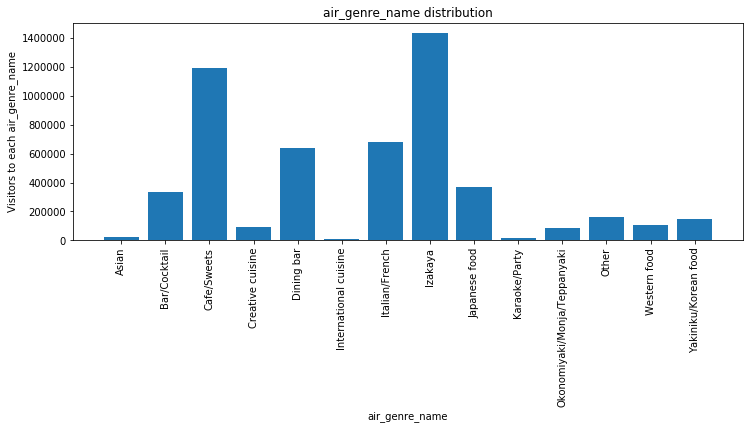

In [11]:
def plot_visitor_distribution(colname):
    print("=========== Total visitors by %s==========" %colname)
    pdf = df_air_visit_data.groupby([colname],as_index=False)["visitors"].sum()
#     pdf.plot( x=colname, y='visitors', kind='scatter')
#     plt.show()
#     plt.plot(pdf[colname],pdf.visitors)
#     plt.show()
    plt.plot(pdf[colname],pdf.visitors,'ro')
    plt.show()
    
def plot_bar_visitor_distribution(colname):
    print("=========== visitors by %s==========" %colname)
    pdf = df_air_visit_data.groupby([colname],as_index=False)["visitors"].sum()
    plt.bar(range(len(pdf[colname])), pdf.visitors, tick_label=pdf[colname])
    plt.title('%s distribution'%colname)
    plt.xlabel(colname)
    plt.ylabel('Visitors to each %s'%colname)
    plt.xticks(rotation=90)
    plt.show()
    
    
def plot_visitor_mean_distribution(colname):
    print("=========== Mean visitors by %s==========" %colname)
    pdf = df_air_visit_data.groupby([colname],as_index=False)["visitors"].mean()
#     pdf.plot( x=colname, y='visitors', kind='scatter')
#     plt.show()
#     plt.plot(pdf[colname],pdf.visitors)
#     plt.show()
    plt.plot(pdf[colname],pdf.visitors,'ro')
    plt.show()




plot_visitor_distribution("dayofweek")
plot_visitor_distribution("dayofmonth")
plot_visitor_distribution("holiday_flg")

plot_visitor_mean_distribution("dayofweek")
plot_visitor_mean_distribution("dayofmonth")
plot_visitor_mean_distribution("holiday_flg")
plot_bar_visitor_distribution("air_genre_name")


<Container object of 14 artists>

Text(0.5,1,'Genre distribution')

Text(0.5,0,'Genre name')

Text(0,0.5,'Number of restaurants with genre')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

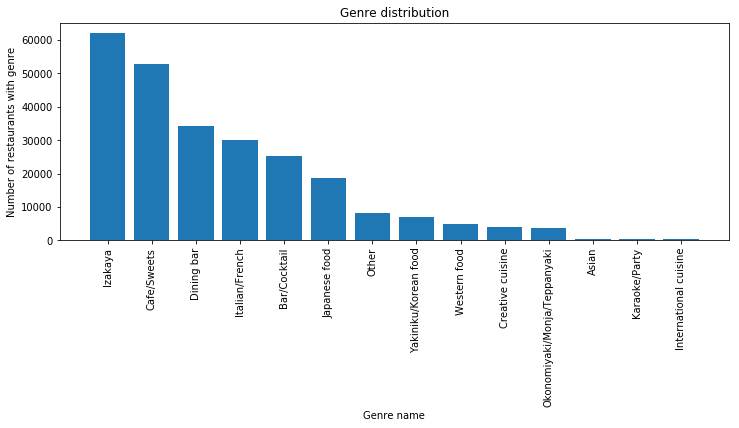

In [12]:
counts = Counter(df_air_visit_data.air_genre_name)
common = counts.most_common()
labels = [item[0] for item in common]
number = [item[1] for item in common]

plt.bar(range(len(common)), number, tick_label=labels)
plt.title('Genre distribution')
plt.xlabel('Genre name')
plt.ylabel('Number of restaurants with genre')
plt.xticks(rotation=90)
plt.show()

<Container object of 15 artists>

Text(0.5,1,'Top 15 area names')

Text(0.5,0,'Area name')

Text(0,0.5,'Number of restaurants in area')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

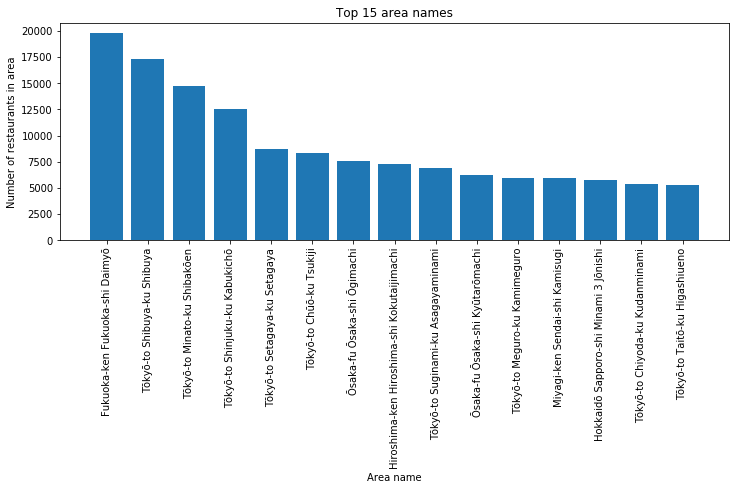

In [13]:
counts = Counter(df_air_visit_data.air_area_name)
common = counts.most_common(15)
labels = [item[0] for item in common]
number = [item[1] for item in common]

plt.bar(range(len(common)), number, tick_label=labels)
plt.title('Top 15 area names')
plt.xlabel('Area name')
plt.ylabel('Number of restaurants in area')
plt.xticks(rotation=90)
plt.show()

In [14]:

column_summary_df = utils.column_summaries(df_air_visit_data)
column_summary_df

Missing Values  % missing of Total Values  \
air_area_name                        0                        0.0   
air_area_name_encoded                0                        0.0   
air_genre_name                       0                        0.0   
air_genre_name_encoded               0                        0.0   
air_lat_long                         0                        0.0   
air_lat_long_encoded                 0                        0.0   
air_store_id                         0                        0.0   
air_store_id_encoded                 0                        0.0   
dayofmonth                           0                        0.0   
dayofweek                            0                        0.0   
dayofyear                            0                        0.0   
holiday_flg                          0                        0.0   
latitude                             0                        0.0   
longitude                            0                        0.0   
visit_date                           0                        0.0   
visitors                             0                        0.0   
weekofyear                           0                        0.0   

                        # Unique Values  # Values as [0] datatype      skew  \
air_area_name                       103                0   object       NaN   
air_area_name_encoded               103            19775    int64 -0.150769   
air_genre_name                       14                0   object       NaN   
air_genre_name_encoded               14              535    int64  0.448789   
air_lat_long                        108                0   object       NaN   
air_lat_long_encoded                108              655    int64  0.084936   
air_store_id                        829                0   object       NaN   
air_store_id_encoded                829              232    int64  0.024401   
dayofmonth                           31                0    int64  0.028617   
dayofweek                             7            31682    int64 -0.039674   
dayofyear                           366                0    int64  0.098768   
holiday_flg                           2           239333    int64  4.097323   
latitude                            108                0  float64  2.687890   
longitude                           108                0  float64 -0.901289   
visit_date                          478                0   object       NaN   
visitors                            204                0    int64  3.307629   
weekofyear                           52                0    int64  0.102288   

                           count        mean         std         min  \
air_area_name                NaN         NaN         NaN         NaN   
air_area_name_encoded   252108.0   50.047964   30.656385    0.000000   
air_genre_name               NaN         NaN         NaN         NaN   
air_genre_name_encoded  252108.0    5.268123    3.121573    0.000000   
air_lat_long                 NaN         NaN         NaN         NaN   
air_lat_long_encoded    252108.0   50.019059   28.936462    0.000000   
air_store_id                 NaN         NaN         NaN         NaN   
air_store_id_encoded    252108.0  412.701513  239.698964    0.000000   
dayofmonth              252108.0   15.591830    8.670745    1.000000   
dayofweek               252108.0    3.019678    1.923985    0.000000   
dayofyear               252108.0  173.916798  112.625822    1.000000   
holiday_flg             252108.0    0.050673    0.219329    0.000000   
latitude                252108.0   35.613121    2.044473   33.211967   
longitude               252108.0  137.357865    3.671577  130.195555   
visit_date                   NaN         NaN         NaN         NaN   
visitors                252108.0   20.973761   16.757007    1.000000   
weekofyear              252108.0   24.961441   16.003421    1.000000   

                               25%         50%         75%   

In [15]:
sample_sub["visitors"] = y_preds

In [16]:
sample_sub.to_csv("results/EDA_1.csv",index=False,columns=["id","visitors"])

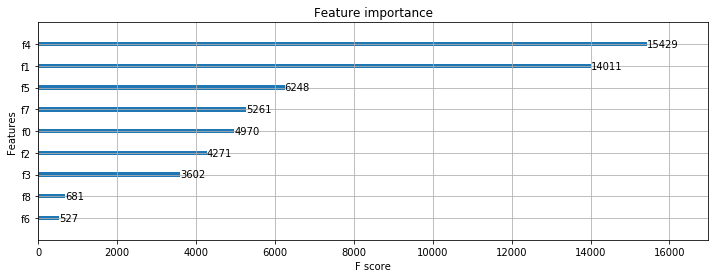

feature  importance
4               dayofyear   28.052727
1    air_store_id_encoded   25.474545
5               dayofweek   11.360000
7              dayofmonth    9.565454
0  air_genre_name_encoded    9.036364
2   air_area_name_encoded    7.765455
3    air_lat_long_encoded    6.549091
8             holiday_flg    1.238182
6              weekofyear    0.958182

In [17]:
def plot_importance(model,df,features):
    from xgboost import plot_importance
    plot_importance(model)
    plt.show()
    fi=model.feature_importances_

    fn=df[features].columns.values

    df_i=pd.DataFrame({"feature":fn,"importance":fi})
    df_i["importance"] = df_i["importance"]*100
    return df_i.sort_values("importance",ascending=False)

plot_importance(xgr,df_air_visit_data,features)

In [21]:
def plot_ts_for_restaurant(restaurant,logy=False):
    dfs1 = df_air_visit_data[df_air_visit_data["air_store_id"]==restaurant][["visitors","visit_date"]]
    dfs1.visit_date = pd.to_datetime(dfs1.visit_date)
    ts = Series(dfs1.visitors.values, index=dfs1.visit_date)
    ts.plot(logy=logy)
    moving_avg = pd.rolling_mean(ts,30)
    plt.plot(moving_avg, color='red')
    

829

/Users/ahemf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  


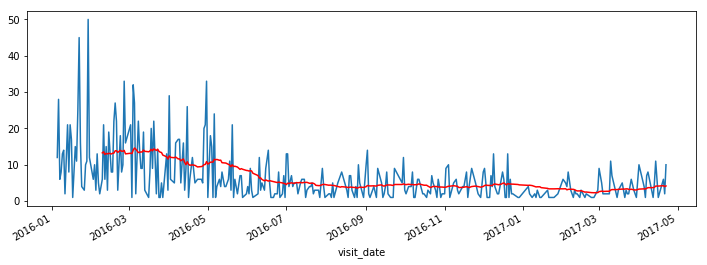

/Users/ahemf/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


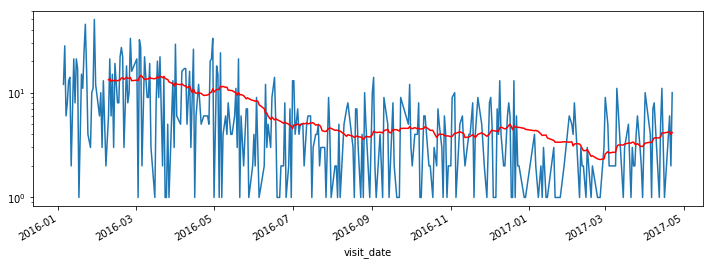

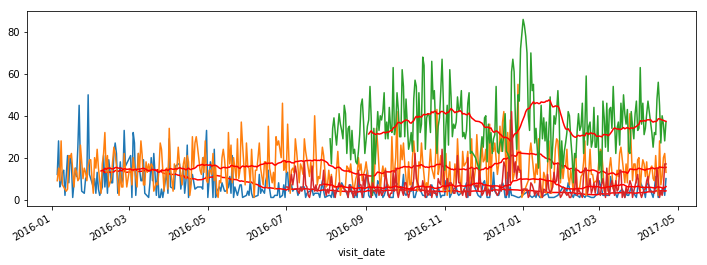

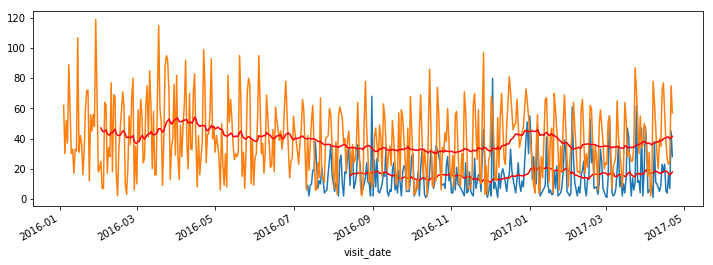

In [22]:
len(df_air_visit_data.air_store_id.unique())
plot_ts_for_restaurant('air_25e9888d30b386df',False)
plt.show()
plot_ts_for_restaurant('air_25e9888d30b386df',True)
plt.show()

plot_ts_for_restaurant('air_25e9888d30b386df')
plot_ts_for_restaurant('air_64d4491ad8cdb1c6')
plot_ts_for_restaurant('air_6902e4ec305b3d08')
plot_ts_for_restaurant('air_256be208a979e023')

plt.show()

plot_ts_for_restaurant('air_cfcc94797d2b5d3d')
plot_ts_for_restaurant('air_03963426c9312048')



In [36]:
def variance_with_lagged_timeseries(restaurant,lag):
    dfs1 = df_air_visit_data[df_air_visit_data["air_store_id"]==restaurant][["visitors"]]
    arr=dfs1.visitors.values
    lags = arr[:lag]
    arr2 = np.delete(arr, [i for i in range(lag)], axis=0)
    arr2 = np.append(arr2,lags, axis=0)
    cov=np.corrcoef(arr,arr2)[0,1]
    logcov=np.corrcoef(np.log1p(arr),np.log1p(arr2))[0,1]
    
    print("\ncorrelation = %s" %cov)
    print("Logged correlation = %s" %cov)
    
    
def diff_timeseries(restaurant,lag):
    dfs1 = df_air_visit_data[df_air_visit_data["air_store_id"]==restaurant][["visitors"]]
    arr=dfs1.visitors.values
    arr2 = np.diff(arr,lag)
    arr2 = np.append(arr2,np.zeros(lag))
    cov=np.abs(np.corrcoef(arr,arr2)[0,1])
    logcov=np.corrcoef(np.log1p(arr),np.log1p(arr2))[0,1]
    
    print("\ncorrelation = %s" %cov)
    print("Logged correlation = %s" %cov)
    

    

    
    
    
  
    

In [37]:
diff_timeseries('air_25e9888d30b386df',1)
diff_timeseries('air_64d4491ad8cdb1c6',1)
diff_timeseries('air_6902e4ec305b3d08',1)
diff_timeseries('air_256be208a979e023',1)
print("==")

diff_timeseries('air_25e9888d30b386df',2)
diff_timeseries('air_64d4491ad8cdb1c6',2)
diff_timeseries('air_6902e4ec305b3d08',2)
diff_timeseries('air_256be208a979e023',2)


correlation = 0.608261203932
Logged correlation = 0.608261203932

correlation = 0.690150708426
Logged correlation = 0.690150708426

correlation = 0.551340612585
Logged correlation = 0.551340612585

correlation = 0.599634138354
Logged correlation = 0.599634138354
==

correlation = 0.349012461289
Logged correlation = 0.349012461289

correlation = 0.36221925746
Logged correlation = 0.36221925746

correlation = 0.231322820983
Logged correlation = 0.231322820983

correlation = 0.28417656042
Logged correlation = 0.28417656042


/Users/ahemf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log1p
/Users/ahemf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log1p


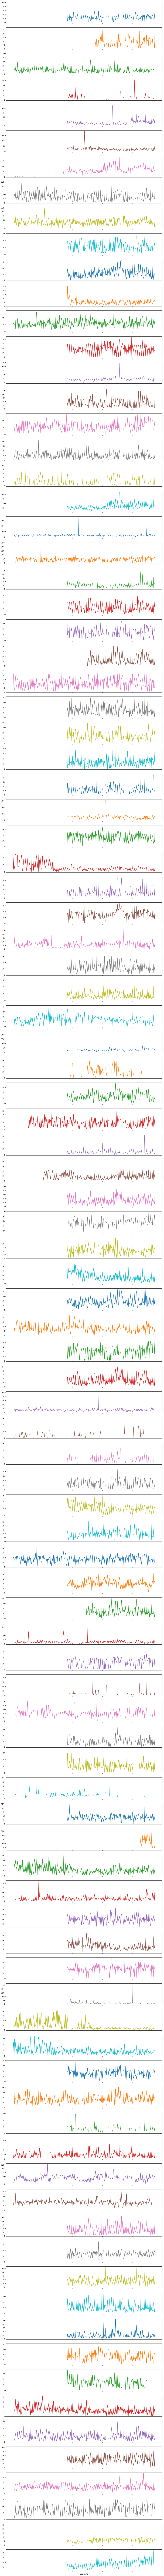

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 300

t = (df_air_visit_data.set_index(["air_store_id", "visit_date"])["visitors"].unstack().iloc[:100].T.plot(legend=None, subplots = True))

In [ ]:
df_air_visit_data.visitors.unstack()